In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import dask
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


In [2]:
# read daily data
processed_dfs = []
for filename in sorted(os.listdir('data/aggregated_individual_data/')):
    with open('data/aggregated_individual_data/'+filename, 'r') as f: # open in readonly mode
        df = pd.read_csv(f)
        df.drop('Unnamed: 0', inplace=True, axis = 1)
        processed_dfs.append(df)

In [3]:
example = processed_dfs[1].copy()
example.head()

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,sleep
0,2014-03-16,6,6.5,-0.5,0.50,NaN,746.315000,0.0,0.0,116.333,...,0.0,0.0,0.0,48.325,39.985,0.000,0.0,0.0,NaN,15.424525
1,2014-03-17,0,6.5,0.5,0.00,0.145299,8669.900001,6.0,0.0,1392.999,...,0.0,0.0,0.0,128.881,123.806,0.000,0.0,0.0,NaN,12.060846
2,2014-03-18,1,8.0,0.8,1.00,0.351584,6820.626001,15.0,1.0,2703.184,...,0.0,0.0,0.0,89.302,212.871,0.000,0.0,0.0,NaN,13.511535
3,2014-03-19,2,7.4,0.2,0.60,0.452052,7920.775000,3.0,1.0,1524.853,...,0.0,0.0,0.0,97.805,51.841,567.165,0.0,0.0,NaN,15.624280
4,2014-03-20,3,6.5,-0.5,0.25,0.355026,4095.841002,6.0,0.0,1519.766,...,0.0,0.0,0.0,94.651,94.488,0.000,0.0,0.0,NaN,16.962416


In [4]:
example.describe()

,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,sleep
count,35.000000,35.000000,35.000000,35.000000,30.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.0,35.0,35.0,35.000000,35.000000,35.000000,35.0,35.000000,0.0,35.000000
mean,2.914286,6.817143,-0.412857,0.365714,0.360364,4721.334029,6.285714,0.800000,1738.362086,2088.807714,...,0.0,0.0,0.0,92.321686,424.957143,179.552829,0.0,4.590914,NaN,13.464322
std,2.048980,0.777718,0.646068,0.444206,0.106075,2764.935862,5.238834,1.278786,2892.651917,1228.711820,...,0.0,0.0,0.0,135.720695,633.064967,305.284903,0.0,17.957793,NaN,3.064394
min,0.000000,5.000000,-2.000000,-0.600000,0.145299,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,NaN,6.925842
25%,1.000000,6.500000,-0.875000,0.000000,0.289654,3048.169000,3.000000,0.000000,852.637000,1374.441500,...,0.0,0.0,0.0,36.147000,102.456500,0.000000,0.0,0.000000,NaN,12.000000
50%,3.000000,6.800000,-0.400000,0.400000,0.363477,4680.699999,5.000000,1.000000,1278.506000,2080.793000,...,0.0,0.0,0.0,66.363000,197.340000,0.000000,0.0,0.000000,NaN,13.299894
75%,5.000000,7.300000,0.000000,0.750000,0.443299,6755.091501,9.000000,1.000000,1764.624000,2943.256500,...,0.0,0.0,0.0,104.606500,388.144000,328.271500,0.0,0.000000,NaN,15.673454
max,6.000000,8.250000,0.800000,1.000000,0.610627,9488.749001,27.000000,7.000000,17745.090000,4786.894000,...,0.0,0.0,0.0,820.488000,2709.468000,1236.239000,0.0,84.488000,NaN,19.910520


In [5]:
vars = ['time', 'weekday', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'sleep', 'sleep_before', 'mood_2days', 'mood_yesterday', 'mood_target', 'target_bw' ]

forest_data = pd.DataFrame(columns = vars)

n_days = 3

for i, df_org in enumerate(processed_dfs):
    df = df_org.copy()

    for j, col in enumerate(example.columns[3:len(vars)]):
        df[col] = (df[col]-df[col].min())/(df[col].max() - df[col].min())
        #df[col] = (df[col]-df[col].mean())
        df[col] = df[col].fillna(0)
        
    for j in range(len(df)-n_days-1):
        means = pd.DataFrame(df.iloc[j:j+n_days, 2:len(example.columns)].mean())
        forest_data = pd.concat([forest_data, means.transpose()], ignore_index=True)
        forest_data.iloc[-1, 0] = df['time'].iloc[j+n_days+1]
        forest_data.iloc[-1, 1] = df['weekday'].iloc[j+n_days+1]
        forest_data.iloc[-1, -5] = df['sleep'].iloc[j+n_days+1]
        forest_data.iloc[-1, -4] = df['mood'].iloc[j+n_days-1]
        forest_data.iloc[-1, -3] = df['mood'].iloc[j+n_days]
        forest_data.iloc[-1, -2] = df['mood'].iloc[j+n_days+1]


# delete columns with too many nan or 0 values
for col in forest_data.columns:
    if (sum(forest_data[col] == 0)/len(forest_data[col])) > 0.5:
        forest_data = forest_data.drop(col, axis = 1)

forest_data['target_bw'] = forest_data['mood_target'] - forest_data['mood_yesterday']
forest_data.fillna(0)
forest_data['mood_target'] = forest_data['mood_target'].astype(int)

In [8]:
print(len(forest_data))
forest_data.drop(forest_data.index[(forest_data['mood_target'] < 5) | (forest_data['mood_target'] > 8)], inplace=True, axis='index')
print(len(forest_data))
print(max(forest_data['mood_target']))
print(min(forest_data['mood_target']))

1043
1043
8
5


<Axes: >

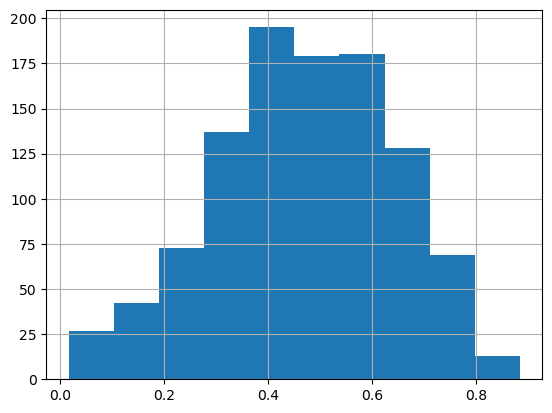

In [9]:
forest_data['sleep'].hist()

In [10]:
# labels = ['vl', 'l', 'm', 'h', 'vh']
# # build classes
# for i, col in enumerate(forest_data.columns[2:len(vars)]):
#     forest_data[col+'class'] = pd.cut(forest_data[col], 5, labels=labels)

In [11]:
forest_data.head()

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.other,appCat.social,appCat.travel,appCat.utilities,sleep,sleep_before,mood_2days,mood_yesterday,mood_target,target_bw
0,2014-03-25,1,6.483333,0.674074,0.466667,0.544040,0.258174,0.300000,0.083333,0.084434,...,0.101140,0.347946,0.196692,0.154879,0.392335,0.529645,6.6,5.8,7,1.2
1,2014-03-26,2,6.333333,0.822222,0.383333,0.496246,0.255329,0.433333,0.083333,0.045470,...,0.055194,0.325006,0.094369,0.116291,0.486050,0.192946,5.8,7.0,6,-0.6
2,2014-03-27,3,6.466667,0.844444,0.383333,0.365867,0.396236,0.333333,0.083333,0.042015,...,0.069381,0.403589,0.086667,0.100905,0.407603,0.327224,7.0,6.4,7,0.6
3,2014-03-28,4,6.400000,0.785185,0.383333,0.510295,0.639396,0.333333,0.083333,0.041981,...,0.095778,0.643153,0.086667,0.153793,0.354383,0.48541,6.4,7.0,6,-0.6
4,2014-03-29,5,6.800000,0.666667,0.716667,0.651682,0.780672,0.066667,0.166667,0.054592,...,0.088225,0.542698,0.009768,0.149692,0.349939,0.262787,7.0,6.4,8,1.6


In [12]:
# delete constant columns
# forest_data = forest_data.loc[:, (forest_data != forest_data.iloc[0]).any()] 
# len(forest_data.columns)

In [13]:
wood = ['weekday', 'mood',
       'activity', 'screen', 'call', 'sleep_before', 'mood_yesterday']

#X = forest_data.loc[:, wood].copy()
X = forest_data.iloc[:,1:-2].copy()

#labels = ['vl', 'l', 'ml', 'm', 'mh', 'h', 'vh']
labels = ['vl', 'l', 'm', 'h', 'vh']
#labels = ['l', 'm', 'h']
#labels = ['three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
# y = pd.cut(forest_data['mood_target'], 5, labels=labels)
# y = y.to_numpy()
y = forest_data.loc[:, 'mood_target'].copy().astype(int)

(array([  0.,   0.,   0.,   0.,   0.,  53., 329., 548., 113.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

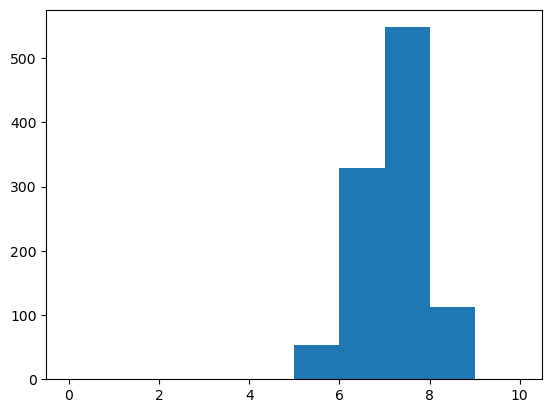

In [14]:
bins = np.arange(0,11,1)
plt.hist(y, bins=bins)

In [15]:
min(y)

5

In [16]:
X.head()

,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,appCat.utilities,sleep,sleep_before,mood_2days,mood_yesterday
0,1,6.483333,0.674074,0.466667,0.544040,0.258174,0.300000,0.083333,0.084434,0.321474,0.062003,0.101140,0.347946,0.196692,0.154879,0.392335,0.529645,6.6,5.8
1,2,6.333333,0.822222,0.383333,0.496246,0.255329,0.433333,0.083333,0.045470,0.387357,0.060346,0.055194,0.325006,0.094369,0.116291,0.486050,0.192946,5.8,7.0
2,3,6.466667,0.844444,0.383333,0.365867,0.396236,0.333333,0.083333,0.042015,0.473781,0.056256,0.069381,0.403589,0.086667,0.100905,0.407603,0.327224,7.0,6.4
3,4,6.400000,0.785185,0.383333,0.510295,0.639396,0.333333,0.083333,0.041981,0.688534,0.093124,0.095778,0.643153,0.086667,0.153793,0.354383,0.48541,6.4,7.0
4,5,6.800000,0.666667,0.716667,0.651682,0.780672,0.066667,0.166667,0.054592,0.716141,0.084985,0.088225,0.542698,0.009768,0.149692,0.349939,0.262787,7.0,6.4


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Hyperparameter tuning
param_dist = {'n_estimators': randint(10,100),
              'max_depth': randint(1,15)}

# Create a random forest classifier
rf = RandomForestClassifier(n_jobs = -1)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=100)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14721b0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x146daf710>})

In [19]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 92}


In [20]:
#rf = RandomForestClassifier(max_depth = 5, n_estimators = 50, n_jobs = -1, class_weight='balanced_subsample')#, criterion='absolute_error')
rf = best_rf

In [21]:
rf = rf.fit(X_train, y_train)

In [22]:
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

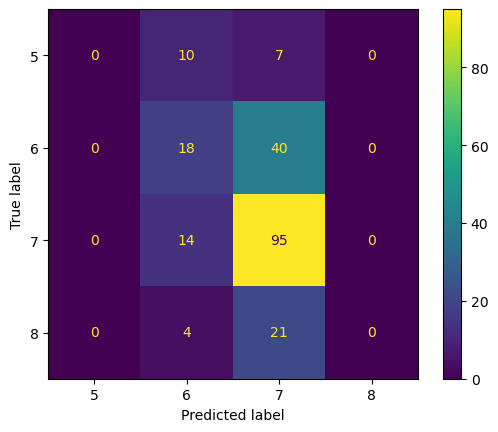

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           5       0.00      0.00      0.00        17
           6       0.39      0.31      0.35        58
           7       0.58      0.87      0.70       109
           8       0.00      0.00      0.00        25

    accuracy                           0.54       209
   macro avg       0.24      0.30      0.26       209
weighted avg       0.41      0.54      0.46       209



/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nik/opt/miniconda3/envs/DMT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

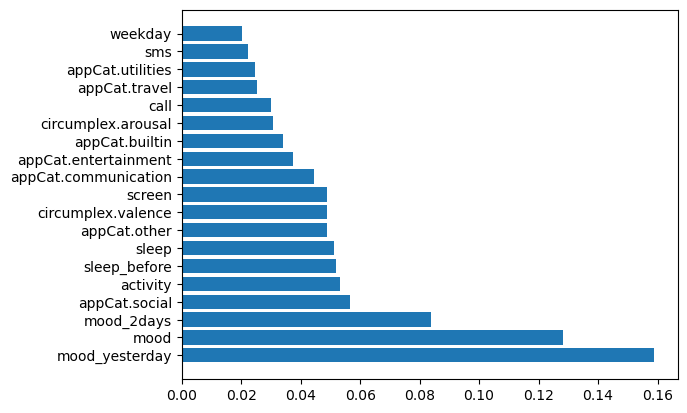

In [25]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

fig = plt.figure()
plt.barh(feature_importances.index,feature_importances.importance)

plt.show()
#fig.savefig('rf_importance.pdf')

In [26]:
rf.class_weight = 'balanced_subsample'
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

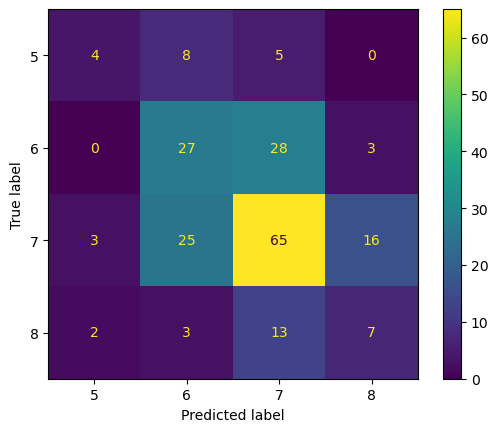

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           5       0.44      0.24      0.31        17
           6       0.43      0.47      0.45        58
           7       0.59      0.60      0.59       109
           8       0.27      0.28      0.27        25

    accuracy                           0.49       209
   macro avg       0.43      0.39      0.40       209
weighted avg       0.49      0.49      0.49       209



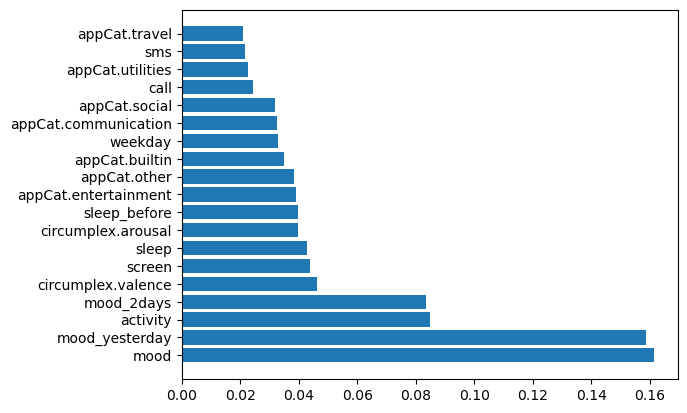

In [29]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

fig = plt.figure()
plt.barh(feature_importances.index,feature_importances.importance)

plt.show()

In [30]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(max_depth = 7, n_estimators = 50, n_jobs = -1, class_weight='balanced_subsample')
rfe = RFE(estimator=rf, n_features_to_select=10)
pipeline = Pipeline(steps=[('s',rfe),('m',rf)])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

In [32]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.548 (0.053)


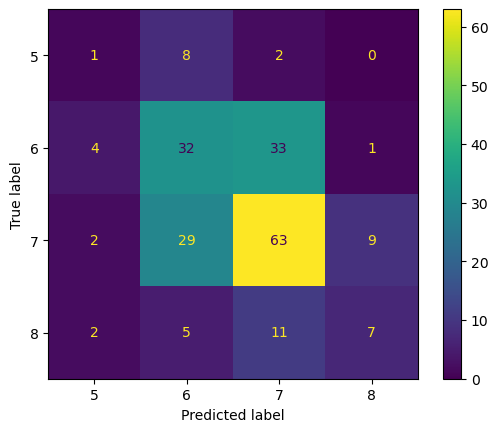

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           5       0.11      0.09      0.10        11
           6       0.43      0.46      0.44        70
           7       0.58      0.61      0.59       103
           8       0.41      0.28      0.33        25

    accuracy                           0.49       209
   macro avg       0.38      0.36      0.37       209
weighted avg       0.48      0.49      0.49       209



In [36]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

fig = plt.figure()
plt.barh(feature_importances.index,feature_importances.importance)

plt.show()

ValueError: Shape of passed values is (10, 1), indices imply (19, 1)